# Exercise 4: Adsorption models

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Model templates

Again, we start with defining a function that creates a pre-configured model model to reduce the amount of required typing.

In [2]:
# Do not delete!
def create_cstr_template(adsorption_model, adsorption_parameters, n_bound):
    """
    Parameters
    ----------
    
    adsorption_model : str
        Adsorption model
    adsorption_parameters : dict
        dictionary with model parameters
    n_bound : list
        list of bound states for every component
    """
    Q = 1e-3
    n_comp = len(n_bound)
    
    model = get_cadet_template(n_units=2)
    
    # INLET
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = n_comp
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

    # CSTR
    model.root.input.model.unit_001.unit_type = 'CSTR'
    model.root.input.model.unit_001.ncomp = n_comp
    model.root.input.model.unit_001.init_volume = 1e-3
    model.root.input.model.unit_001.porosity = 0.5
    model.root.input.model.unit_001.init_c = n_comp*[0]
    model.root.input.model.unit_001.init_q = n_comp*[0]
    model.root.input.model.unit_001.flow_rate_filter = Q


    model.root.input.model.unit_001.nbound = n_bound
    model.root.input.model.unit_001.adsorption_model = adsorption_model
    model.root.input.model.unit_001.adsorption = adsorption_parameters
    
    # Sections and Switches
    model.root.input.solver.sections.nsec = 1
    model.root.input.solver.sections.section_times = [0.0, 10]
    
    model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[0]
    model.root.input.model.unit_000.sec_000.lin_coeff = n_comp*[1]

    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q]


    return model

def plot_cstr_results(model):
    solution_bulk = model.root.output.solution.unit_001.solution_bulk
    solution_solid = model.root.output.solution.unit_001.solution_solid

    plt.figure()
    plt.title('Isotherm')
    plt.plot(solution_bulk, solution_solid)
    plt.xlabel('$c_{bulk}$')
    plt.ylabel('$c_{solid}$')

In [3]:
# Do not delete!
def create_column_template(adsorption_model, adsorption_parameters, n_bound, c_feed):
    """
    Parameters
    ----------
    
    adsorption_model : str
        Adsorption model
    adsorption_parameters : dict
        dictionary with model parameters
    n_bound : list
        list of bound states for every component
    c_feed : list
        list of feed concentrations
    """
    n_comp = len(c_feed)
    Q = 1e-3
    
    model = get_cadet_template(n_units=3)
    
    # Unit Operations
    ## Inlet
    model.root.input.model.unit_000.unit_type = 'INLET'
    model.root.input.model.unit_000.ncomp = n_comp
    model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

    model.root.input.model.unit_000.sec_000.const_coeff = c_feed

    # Tubular reactor
    model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
    model.root.input.model.unit_001.ncomp = n_comp
    model.root.input.model.unit_001.col_length = 0.5
    model.root.input.model.unit_001.cross_section_area = 0.1
    model.root.input.model.unit_001.total_porosity = 0.5
    model.root.input.model.unit_001.par_radius = 1e-6
    model.root.input.model.unit_001.col_dispersion = 1e-6
    model.root.input.model.unit_001.init_c = n_comp * [0]
    model.root.input.model.unit_001.init_q = n_comp * [0]
    
    ### Adsorption
    model.root.input.model.unit_001.nbound = n_bound
    model.root.input.model.unit_001.adsorption_model = adsorption_model
    model.root.input.model.unit_001.adsorption = adsorption_parameters

    ### Discretization
    set_discretization(model)

    ## Outlet
    model.root.input.model.unit_002.unit_type = 'OUTLET'
    model.root.input.model.unit_002.ncomp = n_comp

    ## Sections and Switches
    model.root.input.solver.sections.nsec = 1
    model.root.input.solver.sections.section_times = [0.0, 240]
    model.root.input.solver.sections.section_continuity = []

    model.root.input.model.connections.nswitches = 1
    model.root.input.model.connections.switch_000.section = 0
    model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q,
                                                                 1, 2, -1, -1, Q]
    
    return model


def plot_column_results(model):
    time = model.root.output.solution.solution_times
    c = model.root.output.solution.unit_001.solution_outlet
    
    plt.figure()
    plt.plot(time, c)
    plt.title('Column (Outlet)')
    plt.xlabel('$time~/~min$')
    plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
    plt.show()

## Exercise 1: Single component Langmuir isotherm with linear gradient

To plot the solid phase concentration as a function of the bulk concentration, we can introduce a linear concentration gradient to the `CSTR` that has an initial concentration of $0~g \cdot L^{-1}$.
For this purpose, we will make use of the `flowrate_filter` function of the `CSTR` (see [here](https://cadet.github.io/interface/unit_operations/cstr.html)).
This way, we can add mass (or particles) to the tank without increasing it's volume.
For this considereation, it is important to assume rapid equilibrium.

***Hint:*** For using the `create_cstr_template()` function, pass the adsorption_model as first argument. 
For the adsorption_parametrers, create a `Dict` and assign the model parameters as keys.
Also, you need to pass a list of binding states for every component.

Simulation completed successfully


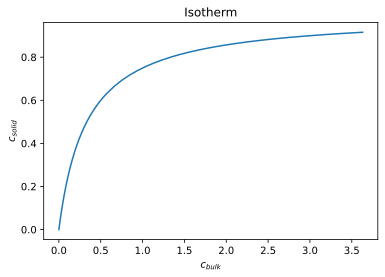

In [4]:
n_bound = [1]

adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.mcl_ka = [3]
adsorption_parameters.mcl_kd = [1]
adsorption_parameters.mcl_qmax = [1]

cstr_model = create_cstr_template(adsorption_model, adsorption_parameters, n_bound)

run_simulation(cstr_model)
plot_cstr_results(cstr_model)

## Exercise 2: Breakthrough curve in a Column

In this example, we look at a column with a `LINEAR` isotherm with $k_{eq, 1} = 2$, and $k_{eq, 2} = 1$.
We want to record the breakthrough curve and for this purpose, a concentration step with $c_{feed} = [1.0, 1.0]~g \cdot L^{-1} $is introduced at $t = 0$. 

***Task:*** Implement the configuration for the adsorption isotherm and pass it to the `create_column_template()` function. You also need to provide the number of can also provide

Try experimenting with:
- The binding strenth.
- The number of components.
- Modify how many components bind.
- Compare kinetic binding with rapid equilibrium.

Simulation completed successfully


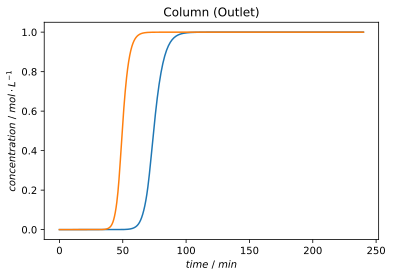

In [5]:
c_feed = [1,1]
n_bound = [1,1]
adsorption_model = 'LINEAR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.lin_ka = [2,1]
adsorption_parameters.lin_kd = [1,1]

column_model = create_column_template(adsorption_model, adsorption_parameters, n_bound, c_feed)

run_simulation(column_model)
plot_column_results(column_model)

## Exercise 3: Langmuir model in Column

Let us consider the same experiment as in the first example, but this time with `MULTI_COMPONENT_LANGMUIR` adsorption model.

with $k_{eq, i} = [2, 1]$, and $q_{max, i} = [10, 10]$.
We again introduce a step with $c_{feed} = [1.0, 1.0]~g \cdot L^{-1} $is introduced at $t = 0$ and the breakthrough curve is recorded.

Try experimenting with:
- The binding strenth.
- The number of components.
- Modify how many components bind.
- Compare kinetic binding with rapid equilibrium.

Simulation completed successfully


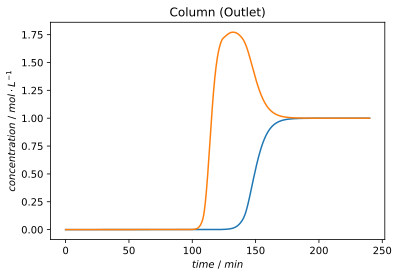

In [6]:
c_feed = [1,1]
n_bound = [1,1]
adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.mcl_ka = [2,1]
adsorption_parameters.mcl_kd = [1,1]
adsorption_parameters.mcl_qmax = [10,10]

column_model = create_column_template(adsorption_model, adsorption_parameters, n_bound, c_feed)

run_simulation(column_model)
plot_column_results(column_model)

## Bonus Exercise

There are many other models implemented in `CADET`. 
Some binding models can account for multiple binding states, others allow for mobile phase modulators.
Moreover, binding models can use external functions for modifying the values of the parameters during the simulation.
This could be used to model other effects like temperature that have an influence on the binding strength.

Try implementing some of the more advanced isotherms and features.